# Forecasting 

![extrapolating](https://imgs.xkcd.com/comics/extrapolating.png)

In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Previous cycle  


______________________________


We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()  
- Prepare data: prepare.prep_store_data()  
- Split data: prepare.split_store_data()  

Then we will forecast and evaluate using each method. 

## Imports

In [68]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

## Acquire

We will acquire the store-item-demand data for this lesson from the sql database. 

In [2]:
# define get_connection
def get_db_url(url):
    url = f'mysql+pymysql://{user}:{password}@{host}/{url}'
    return url

In [3]:
# assign query to variable 

#query = "SELECT stores.*, items. *, sales.sale_date, sales.sale_amount FROM sales JOIN stores USING(store_id) JOIN items USING (item_id);"

In [4]:
# read sql query using pd.read_sql()
df = pd.read_csv('sales_prep.csv')

In [5]:
# take a peek
# df.head()

## Prepare


1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents. 
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!

In [6]:
# sale_date to datetime
df.assign(ds = pd.to_datetime(df.sale_date)).sort_values('ds')

,sale_date,item,sale_amount,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,...,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,day_of_week,sales_total,ds
0,2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,...,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,1,Tuesday,10.92,2013-01-01 00:00:00+00:00
341,2013-01-01 00:00:00+00:00,38,50.0,677447,2,9255 FM 471 West,San Antonio,2,TX,78251,...,Sundown Naturals,38,Sundown Naturals Essential Electrolytes Tropic...,3.45,30768540548,30768540548,1,Tuesday,172.50,2013-01-01 00:00:00+00:00
340,2013-01-01 00:00:00+00:00,35,38.0,624493,3,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,...,Natures Way,35,Natures Way Forskohlii - 60 Ct,5.19,33674100066,33674100066,1,Tuesday,197.22,2013-01-01 00:00:00+00:00
339,2013-01-01 00:00:00+00:00,37,9.0,661013,3,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,...,Nakano,37,Nakano Seasoned Rice Vinegar Original,9.59,73575295003,73575295003,1,Tuesday,86.31,2013-01-01 00:00:00+00:00
338,2013-01-01 00:00:00+00:00,37,18.0,659187,2,9255 FM 471 West,San Antonio,2,TX,78251,...,Nakano,37,Nakano Seasoned Rice Vinegar Original,9.59,73575295003,73575295003,1,Tuesday,172.62,2013-01-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912658,2017-12-31 00:00:00+00:00,1,23.0,1826,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,...,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12,Sunday,19.32,2017-12-31 00:00:00+00:00
912657,2017-12-31 00:00:00+00:00,3,59.0,51128,8,15000 San Pedro Ave,San Antonio,8,TX,78232,...,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,23923330139,23923330139,12,Sunday,143.37,2017-12-31 00:00:00+00:00
912656,2017-12-31 00:00:00+00:00,3,39.0,54780,10,8503 NW Military Hwy,San Antonio,10,TX,78231,...,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,23923330139,23923330139,12,Sunday,94.77,2017-12-31 00:00:00+00:00
912669,2017-12-31 00:00:00+00:00,2,79.0,21912,2,9255 FM 471 West,San Antonio,2,TX,78251,...,Caress,2,Caress Velvet Bliss Ultra Silkening Beauty Bar...,6.44,11111065925,11111065925,12,Sunday,508.76,2017-12-31 00:00:00+00:00


In [7]:
# create dollars_sold = sale_amount * item_price
df.assign(dollars_sold = df.sale_amount * df.item_price)

,sale_date,item,sale_amount,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,...,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,day_of_week,sales_total,dollars_sold
0,2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,...,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,1,Tuesday,10.92,10.92
1,2013-01-01 00:00:00+00:00,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,...,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,Tuesday,218.40,218.40
2,2013-01-01 00:00:00+00:00,46,27.0,832657,7,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,...,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,1,Tuesday,125.55,125.55
3,2013-01-01 00:00:00+00:00,12,54.0,213643,8,15000 San Pedro Ave,San Antonio,8,TX,78232,...,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,Tuesday,453.60,453.60
4,2013-01-01 00:00:00+00:00,12,35.0,215469,9,735 SW Military Dr,San Antonio,9,TX,78221,...,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,Tuesday,294.00,294.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-31 00:00:00+00:00,34,21.0,619014,9,735 SW Military Dr,San Antonio,9,TX,78221,...,Halls,34,Halls Menthol Cough Suppresant/oral Anesthetic...,4.17,312546628694,312546628694,12,Sunday,87.57,87.57
912996,2017-12-31 00:00:00+00:00,34,32.0,620840,10,8503 NW Military Hwy,San Antonio,10,TX,78231,...,Halls,34,Halls Menthol Cough Suppresant/oral Anesthetic...,4.17,312546628694,312546628694,12,Sunday,133.44,133.44
912997,2017-12-31 00:00:00+00:00,35,55.0,622666,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,...,Natures Way,35,Natures Way Forskohlii - 60 Ct,5.19,33674100066,33674100066,12,Sunday,285.45,285.45
912998,2017-12-31 00:00:00+00:00,33,100.0,598928,8,15000 San Pedro Ave,San Antonio,8,TX,78232,...,The First Years,33,Tomy The First Years Gumdrop Orthodontic Pacif...,6.52,71463060078,71463060078,12,Sunday,652.00,652.00


In [8]:
# create items_sold from sale_amount (rename)
df.assign(items_sold = df.sale_amount)

,sale_date,item,sale_amount,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,...,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,day_of_week,sales_total,items_sold
0,2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,...,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,1,Tuesday,10.92,13.0
1,2013-01-01 00:00:00+00:00,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,...,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,Tuesday,218.40,26.0
2,2013-01-01 00:00:00+00:00,46,27.0,832657,7,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,...,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,1,Tuesday,125.55,27.0
3,2013-01-01 00:00:00+00:00,12,54.0,213643,8,15000 San Pedro Ave,San Antonio,8,TX,78232,...,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,Tuesday,453.60,54.0
4,2013-01-01 00:00:00+00:00,12,35.0,215469,9,735 SW Military Dr,San Antonio,9,TX,78221,...,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,Tuesday,294.00,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-31 00:00:00+00:00,34,21.0,619014,9,735 SW Military Dr,San Antonio,9,TX,78221,...,Halls,34,Halls Menthol Cough Suppresant/oral Anesthetic...,4.17,312546628694,312546628694,12,Sunday,87.57,21.0
912996,2017-12-31 00:00:00+00:00,34,32.0,620840,10,8503 NW Military Hwy,San Antonio,10,TX,78231,...,Halls,34,Halls Menthol Cough Suppresant/oral Anesthetic...,4.17,312546628694,312546628694,12,Sunday,133.44,32.0
912997,2017-12-31 00:00:00+00:00,35,55.0,622666,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,...,Natures Way,35,Natures Way Forskohlii - 60 Ct,5.19,33674100066,33674100066,12,Sunday,285.45,55.0
912998,2017-12-31 00:00:00+00:00,33,100.0,598928,8,15000 San Pedro Ave,San Antonio,8,TX,78232,...,The First Years,33,Tomy The First Years Gumdrop Orthodontic Pacif...,6.52,71463060078,71463060078,12,Sunday,652.00,100.0


In [9]:
# resample daily, summing dollars_sold and items_sold
#df.groupby(['ds'])[['dollars_sold', 'items_sold']].sum()

In [10]:
def prep_date(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).sort_values('ds').assign(dollars_sold = df.sale_amount * df.item_price).assign(items_sold = df.sale_amount).groupby(['ds'])[['dollars_sold', 'items_sold']].sum()

In [11]:
df = prep_date(df)

# remove leap days
df = df[df.index != '2016-02-29']

df.head(1)

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiple by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [12]:
df_size = len(df)
df_size

1825

In [13]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .50)
train_size

912

In [14]:
# compute num of rows that are 30% of total rows and assign to variable validate_size

validate_size = int(len(df)* .3)
validate_size

547

In [15]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)
test_size

366

In [16]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

1459

In [17]:
train = df[: train_size]
validate = df[train_size: validate_end_index]
test = df[validate_end_index : ]

# split into train, validation, test

In [18]:
# Checking size
len(train) + len(validate) + len(test) == df_size

True

In [19]:
print(df.head(1)==train.head(1))

                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


In [20]:
pd.concat([train.tail(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-07-01 00:00:00+00:00,164573.20,30703.0
2015-07-02 00:00:00+00:00,178036.64,33134.0


In [21]:
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0
2016-12-31 00:00:00+00:00,128009.31,23792.0


In [22]:
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


In [23]:
validate.tail(1)

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0


In [24]:
test.tail(1)

,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0


**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [25]:
# sum of train, validate and test = total number of rows? 


Does the first row of original df equate to the first row of train? 

In [26]:
# test the row starts


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [27]:
# test the split between validate and test


Is the last row of test the same as the last row of our original dataframe? 

In [28]:
# compare the last row of test to last row of df


Let's plot our data first, viewing where the data is split into train, validate, and test. 

In [29]:
def plot_samples(target_var):
    '''
    this function wil plot the train, validate and test values for a single varibable across all dates
    '''
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)
    

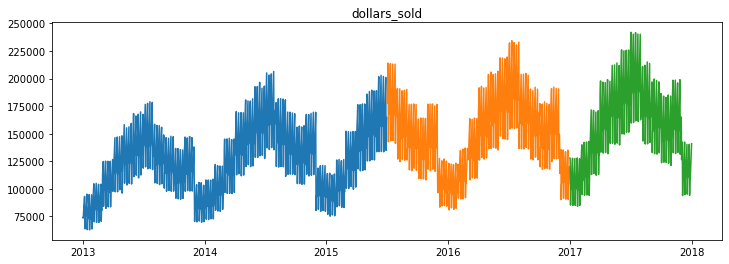

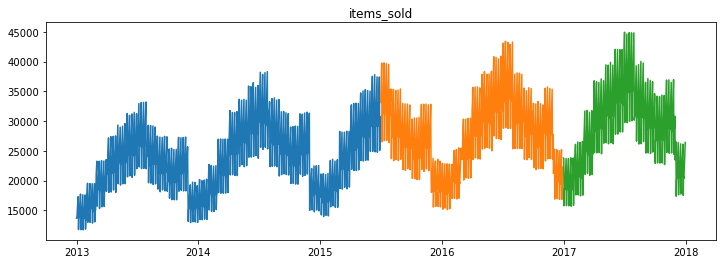

In [30]:
# plot the data points, color by train, validate, test

for col in train.columns:
    plot_samples(col)
plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [31]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    Creating a function to grab rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [122]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(f'--RMSE: {target_var}')
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [33]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [34]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [35]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is goign to take in the model type as a string, the target variable as a string,
    and run the evalute() function to compute the rsme,
    and append to the data frame a row with the model_type, target_var and rmse.
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

## Forecast 

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

In [36]:
# create var 'items' with last observed value

items = int(train['items_sold'][-1:][0])
items
# create dollars 'items' with last observed value

30703

In [37]:
dollars = round(train['dollars_sold'][-1], 2)
dollars

164573.2

In [38]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, index = validate.index)

In [39]:
yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,30703,164573.2
2015-07-03 00:00:00+00:00,30703,164573.2


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

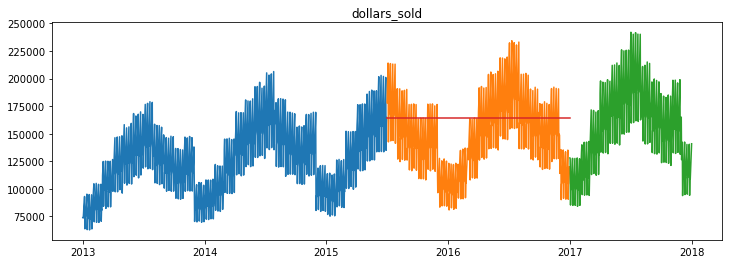

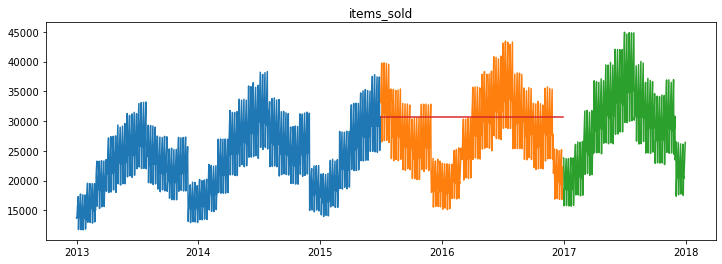

In [40]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [41]:
col = 'items_sold'
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

In [42]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

In [43]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

In [44]:
def make_predictions(items, dollars):
    yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold':[dollars]}, index = validate.index)
    return yhat_df

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

In [45]:
yhat_df = make_predictions(items, dollars)
yhat_df

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,23717.94,127517.85
2015-07-03 00:00:00+00:00,23717.94,127517.85
2015-07-04 00:00:00+00:00,23717.94,127517.85
2015-07-05 00:00:00+00:00,23717.94,127517.85
2015-07-06 00:00:00+00:00,23717.94,127517.85
...,...,...
2016-12-26 00:00:00+00:00,23717.94,127517.85
2016-12-27 00:00:00+00:00,23717.94,127517.85
2016-12-28 00:00:00+00:00,23717.94,127517.85


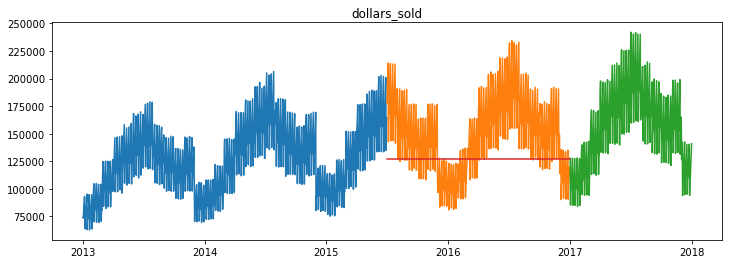

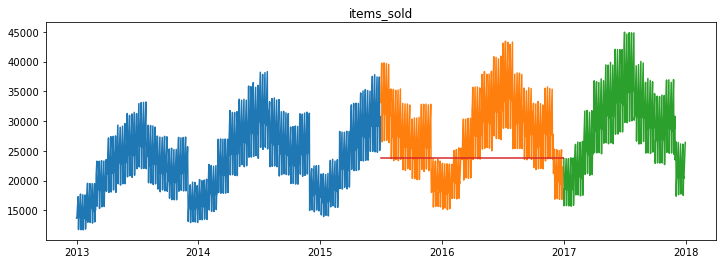

In [46]:
for col in train.columns:
    plot_and_eval(col)

In [47]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)

In [48]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [49]:
period = 30
# use the rolling method, take the mean of the last 30,
# and select the last value that is the last day in train
# round to 2 
# do that for each target variable 
items = round(train['items_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)
items

31433

In [50]:
dollars

168957.91

### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

In [51]:
yhat_df = make_predictions(items, dollars)

In [52]:
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31433,168957.91
2015-07-03 00:00:00+00:00,31433,168957.91
2015-07-04 00:00:00+00:00,31433,168957.91


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

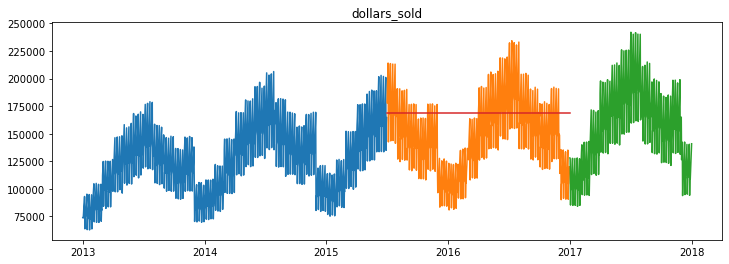

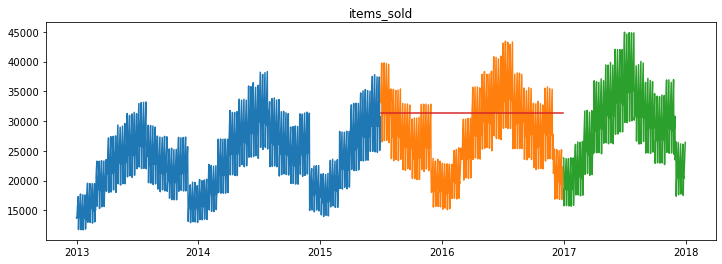

In [53]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using RMSE, and add evaluation metrics to `eval_df`

In [54]:
for col in train.columns:
    eval_df = append_eval_df(model_type="30d moving average", target_var = col)

In [55]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0


Let's try out several other values for periods:

### 15 Day Moving Average

In [56]:
period = 15
items = round(train['items_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)
yhat_df = make_predictions(items, dollars)
for col in train.columns:
    eval_df = append_eval_df(model_type="15d moving average", target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0
6,15d moving average,dollars_sold,37441.0
7,15d moving average,items_sold,6958.0


### 7 Day Moving Average 

In [57]:
period = 7
items = round(train['items_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)
yhat_df = make_predictions(items, dollars)
for col in train.columns:
    eval_df = append_eval_df(model_type="7d moving average", target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0
6,15d moving average,dollars_sold,37441.0
7,15d moving average,items_sold,6958.0
8,7d moving average,dollars_sold,38265.0
9,7d moving average,items_sold,7117.0


### 45 Day Moving Average

In [58]:
period = 45
items = round(train['items_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)
yhat_df = make_predictions(items, dollars)
for col in train.columns:
    eval_df = append_eval_df(model_type="45d moving average", target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0
6,15d moving average,dollars_sold,37441.0
7,15d moving average,items_sold,6958.0
8,7d moving average,dollars_sold,38265.0
9,7d moving average,items_sold,7117.0


Which is best so far? 

In [64]:
# get the min rmse for each variable
eval_df.sort_values(by=['rmse']).groupby('target_var').first()

,model_type,rmse
target_var,,
dollars_sold,last_observed_value,35402.0
items_sold,last_observed_value,6621.0


In [60]:
# filter only the rows that match those rmse to find out 
# which models are best thus far


### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 


**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target. 

dollars_sold 



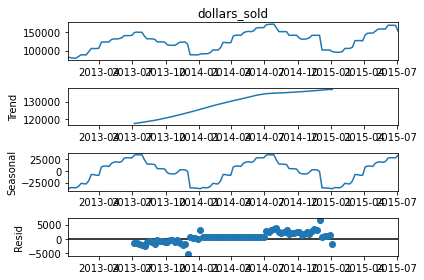

items_sold 



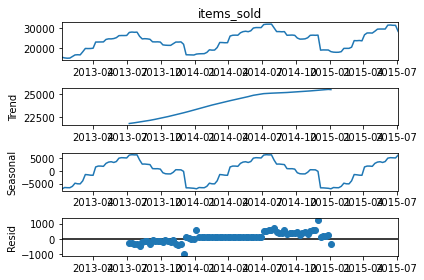

In [69]:
import statsmodels.api as sm

for col in train.columns:
    print(col, '\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

### level = .5 / slope = .5

In [85]:
for col in train.columns:
    # Making the model
    model = Holt(train[col], exponential = False)
    
    # Fitting the model
    model = model.fit(smoothing_level = .5, smoothing_slope = .5, optimized = False)
    
    # Making predictions 
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])
    
    yhat_df[col] = round(yhat, 0)

**Plot Actual vs. Predicted Values**

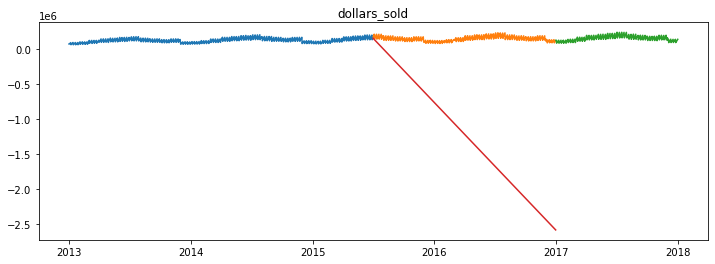

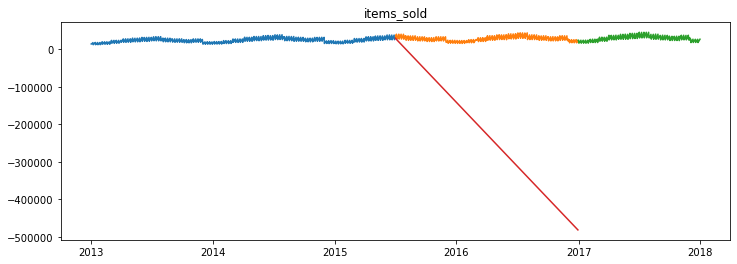

In [86]:
for col in train.columns:
        eval_df = append_eval_df(model_type = 'Holts', target_var = col)
        plot_and_eval(target_var = col)

### level = .1/ slope = .1

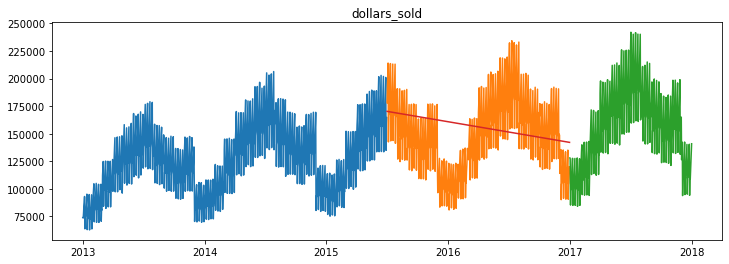

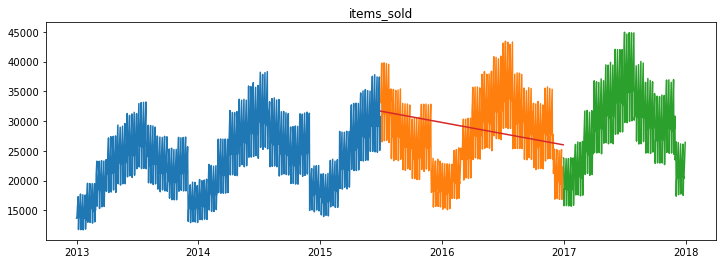

In [95]:
for col in train.columns:
    # Making the model
    model = Holt(train[col], exponential = False)
    
    # Fitting the model
    model = model.fit(smoothing_level = .1, smoothing_slope = .1, optimized = False)
    
    # Making predictions 
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])
    
    yhat_df[col] = round(yhat, 0)
    
for col in train.columns:
        eval_df = append_eval_df(model_type = 'Holts L=.1 S=.1', target_var = col)
        plot_and_eval(target_var = col)

**Evaluate**

In [96]:
# eval_df = eval_df[eval_df.model_type != 'Holts']

In [97]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0
6,15d moving average,dollars_sold,37441.0
7,15d moving average,items_sold,6958.0
8,7d moving average,dollars_sold,38265.0
9,7d moving average,items_sold,7117.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [98]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [ ]:
# year difference
train.diff(365).mean()

**Make Predictions**

In [105]:
# take the values for each day in 2015 and add the average year over year(yoy)(y/y)
yhat_df = train['2015'] + train.diff(365).mean()

In [106]:
yhat_df = yhat_df.set_index(validate.index)

In [107]:
# set yhat_df to index of validate
yhat_df.head()

,dollars_sold,items_sold
ds,,
2016-01-01 00:00:00+00:00,104337.620493,19411.813699
2016-01-02 00:00:00+00:00,112870.770493,20904.813699
2016-01-03 00:00:00+00:00,118245.300493,21983.813699
2016-01-04 00:00:00+00:00,125496.760493,23286.813699
2016-01-05 00:00:00+00:00,88551.940493,16420.813699


**Plot and Evaluate**

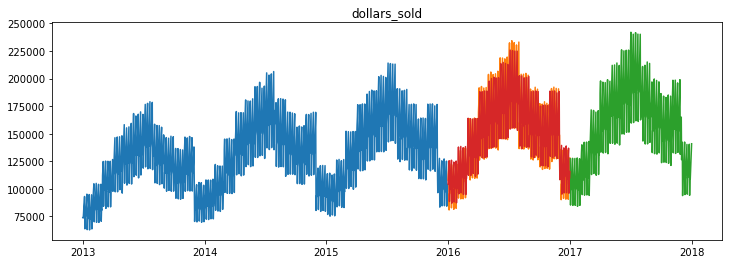

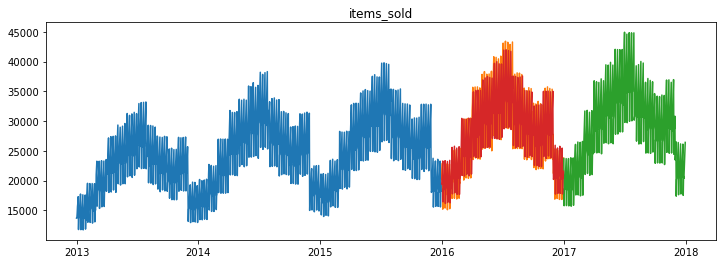

In [108]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'yoy-diff', target_var = col)
    plot_and_eval(target_var = col)

In [109]:
eval_df.sort_values('rmse').groupby('target_var').first()

,model_type,rmse
target_var,,
dollars_sold,yoy-diff,28087.0
items_sold,yoy-diff,5223.0


In [118]:
compare_df = pd.concat([yhat_df.items_sold, validate.items_sold], axis = 1)
compare_df.columns = ['yhat_items', 'actual_items']
compare_df['error'] = compare_df.actual_items - compare_df.yhat_items
compare_df['squared_error'] = compare_df.error * compare_df.error
#compare_df[compare_df.squared_error.mean()]
compare_df

,yhat_items,actual_items,error,squared_error
ds,,,,
2016-01-01 00:00:00+00:00,19411.813699,20158.0,746.186301,5.567940e+05
2016-01-02 00:00:00+00:00,20904.813699,21280.0,375.186301,1.407648e+05
2016-01-03 00:00:00+00:00,21983.813699,22911.0,927.186301,8.596744e+05
2016-01-04 00:00:00+00:00,23286.813699,15199.0,-8087.813699,6.541273e+07
2016-01-05 00:00:00+00:00,16420.813699,17806.0,1385.186301,1.918741e+06
...,...,...,...,...
2016-12-27 00:00:00+00:00,25453.813699,19341.0,-6112.813699,3.736649e+07
2016-12-28 00:00:00+00:00,17754.813699,19560.0,1805.186301,3.258698e+06
2016-12-29 00:00:00+00:00,20588.813699,21111.0,522.186301,2.726785e+05


## Conclusion

Which model did the best? 

In [62]:
# get the min rmse for each variable


# filter only the rows that match those rmse to find out 
# which models are best thus far


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [119]:
# must use same parameters we used from train

yhat = validate + train.diff(365).mean()
# set index to that of test
yhat_df.index = test.index

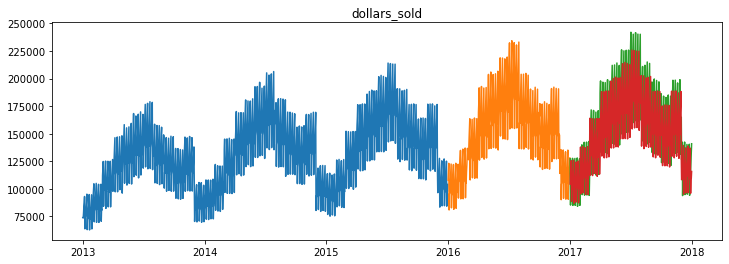

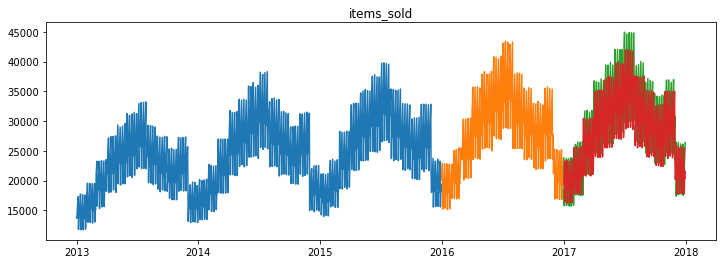

In [121]:
for col in train.columns:
    plot_and_eval(col)
    append_eval_df(model_type = 'yoy-diff-test', target_var = col)

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.